<a href="https://colab.research.google.com/github/ziatdinovmax/atomai/blob/master/examples/notebooks/atomai_training_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Short tutorial on how to use AtomAI's utility functions to prepare training data (beta)

Prepared by Maxim Ziatdinov

E-mail: maxim.ziatdinov@ai4microscopy.com

This notebook shows how to use utility functions in AtomAI to prepare training data from an experimental image when you have the coordinates of atoms in that image. This data can be then used to [train a deep learning model](https://colab.research.google.com/github/ziatdinovmax/atomai/blob/master/examples/notebooks/atomai_atomnet.ipynb) for atom finding. In the absense of atomic coordinates for experimental image(s) one can just simulate the entire training set using "dummy Gaussians" following [this example](https://colab.research.google.com/github/ziatdinovmax/AtomicImageSimulator/blob/master/GenerateTrainingSet.ipynb).

## Install AtomAI

Install AtomAI:

In [1]:
!pip install atomai

Import modules:

In [0]:
from atomai.utils import create_lattice_mask, extract_patches_, datatransform
import numpy as np
import matplotlib.pyplot as plt

## Prepare mask (aka ground truth)

Down(load) data:

In [4]:
download_link = 'https://drive.google.com/uc?id=1_uo7BXjDU-laUAs4Uj1aFqwqfnxi9tpz'
!gdown $download_link -O 'img_w_coord.npy'
img_w_coord = np.load('img_w_coord.npy')
lattice_im = img_w_coord['lattice_img']
xy_atoms_a = img_w_coord['lattice_coord_a']
xy_atoms_b = img_w_coord['lattice_coord_b']
print(lattice_im.shape, xy_atoms_a.shape, xy_atoms_b.shape)

Downloading...
From: https://drive.google.com/uc?id=1_uo7BXjDU-laUAs4Uj1aFqwqfnxi9tpz
To: /content/img_w_coord.npy
118MB [00:01, 105MB/s] 
(3801, 3801) (2, 64932) (2, 65465)


Here we have a single image (```lattice_im```) that shows atomic structure of a ferroelectric material with two sublattices whose coordinates are stored in two different arrays (```xy_atoms_a```, ```xy_atoms_b```). We start by creating two separate masks for the two lattices using ```create_lattice_mask``` utility function. Each mask represents circular objects with constant pixel values centered around the centers of atoms. The image and coordinates were provided by C. Nelson (ORNL). The coordinates were computed using multi-Gaussian peak fitting. While this method allows a reliable identification of the atomic centers, it is a relatively slow method, and it also may not work properly for the images with a high level of noise. Therefore, it makes sense to use the atomic coordinates determined via Gaussian fitting on good images to train a neural network that could generalize and perform fast identification of atomic positions on various kind of images with different noise levels from the same (or similar) system.

In [0]:
lattice_mask_a = create_lattice_mask(lattice_im, xy_atoms_a)
lattice_mask_b = create_lattice_mask(lattice_im, xy_atoms_b)

Notice that it is possibe to pass a custom function for creating mask (aka ground truth) to the ```create_lattice_mask```. The default function for mask creation (which is used here) creates an atom-mask pair for each xy coordinate. We disregard the 'atom' array, which can be used to create synthetic dataset, since we already have an actual experimental image of atoms and use only the 'mask' part. You can pass an additional argument ```rmask``` to ```create_lattice_mask```, which controls the size of mask.

We can treat all the atoms as one class or assing a different class to each atom type:

In [0]:
multiclass = True

if multiclass:
    lattice_mask_backgr = 1 - (lattice_mask_a + lattice_mask_b)
    lattice_mask = np.concatenate(
        (lattice_mask_a[..., None], 
         lattice_mask_b[..., None],
         lattice_mask_backgr[..., None]), # we need to add a background class
        axis=-1)
else:
    lattice_mask = lattice_mask_a + lattice_mask_b
    lattice_mask[lattice_mask>1] = 1

## Generate image-label pairs

We now extract random patches of a selected size from the larger images of lattice and corresponding mask:

(Notice that you should use at least ~1500 image-mask pairs for your training data. Here we generate only 500 pairs just for illustration purposes)

In [36]:
images_all, labels_all = extract_patches_(
    lattice_im, lattice_mask, patch_size=256, num_patches=500, random_state=42)
print(images_all.shape, labels_all.shape)

(500, 256, 256) (500, 256, 256, 3)


We can plot a selected patch from the obtained stack. Notice that this is an overlay plot (a semi-transparent image of mask on top of the original experimental image).

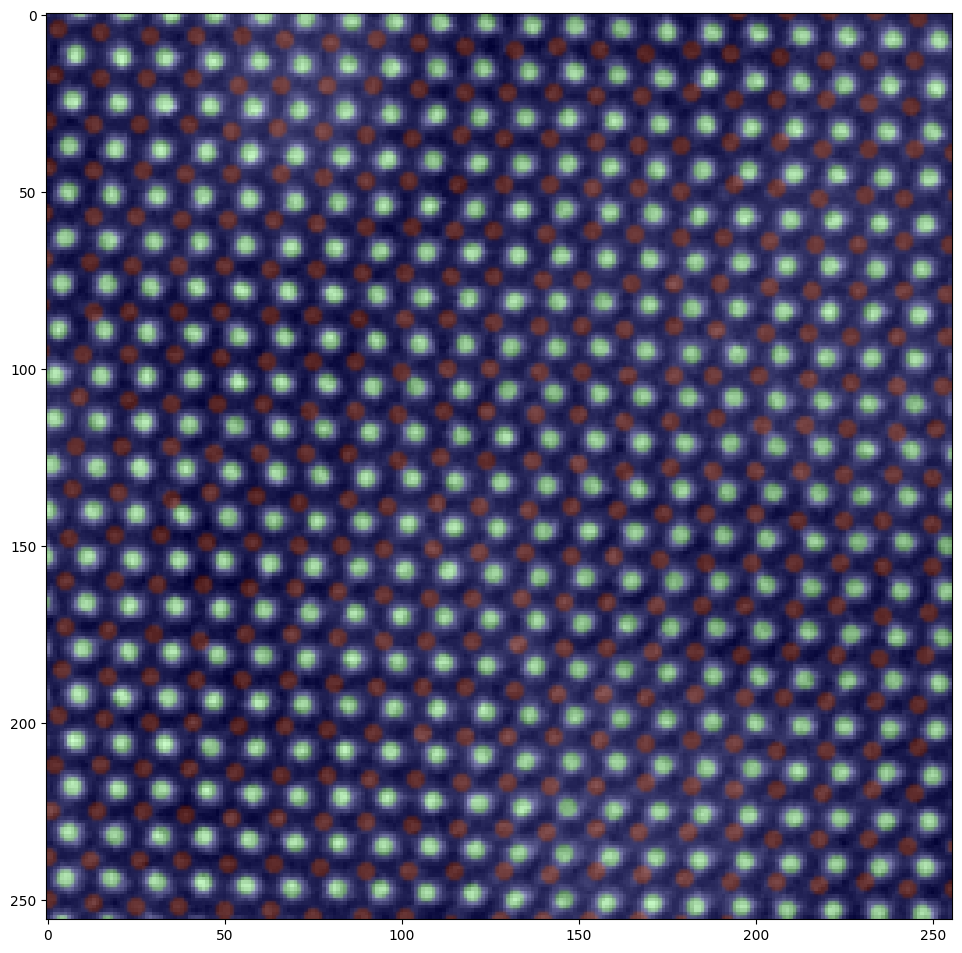

In [39]:
k = 2
plt.figure(figsize=(12, 12), dpi=100)
plt.imshow(images_all[k], cmap='gray')
plt.imshow(labels_all[k], alpha=.2, interpolation='Gaussian')

## Add noise/distortions

In principle, we can just save the generated stacks of subimages and use them for model training. However, to account for different experimental conditions, we can "augment" the current dataset by applying different types of noise and "distortion" to each image in the stack. Notice that noise is applied only to images and not to masks. The "distortions" such as zooming-in and horizontal/vertical flipping are applied to both images and mask.

At the end of the augmentation procedure we will squeeze all the channels into a single channel by setting ```squeeze=True```. This will also make sure that each pixel has a unique class and will remove ambiguous pixels. Hence the output may contain fewer image-mask pairs that the input.

In [40]:
# For a single class case, we still need to explicitly specify the single channel
labels_all = labels_all[..., None] if np.ndim(labels_all) == 3 else labels_all
# Specify size, dimensions
batch_size = len(labels_all) # here we will pass through the augmentor all data at once
dim1, dim2, ch = labels_all.shape[1:]
# Define image distortion/noise parameters
zoom = 1.1 # zoom factor
poisson = [30, 40] # P noise range (scaled units)
gauss = [20, 100] # G noise range (scaled units)
blur = [1, 40] # Blurring range (scaled units)
contrast = [5, 14] # contrast range (< 10 is brighter, > 10 is darker)
salt_and_pepper = [1, 10] # min/max amount of salted/peppered pixels (scaled units)
# Run the augmentor
imaug = utils.datatransform(
    batch_size=batch_size, width=dim1, height=dim2, n_channels=ch,
    dim_order_in='channel_last', dim_order_out='channel_first', 
    gauss=gauss, poisson=poisson, salt_and_pepper=salt_and_pepper,
    contrast=contrast, blur=blur, zoom=zoom, rotation=True,
    squeeze_channels=True, seed=42)
images_all, labels_all = imaug.run(images_all, labels_all)

print(images_all.shape, labels_all.shape)

(274, 1, 256, 256) (274, 256, 256)


We can plot some of the "augmented" image-mask pairs. The neural network will be trained to take an image in the top row as the input and to output a clean image of blobs on a uniform background in the bottom row, from which one can identify the xy centers of atoms.

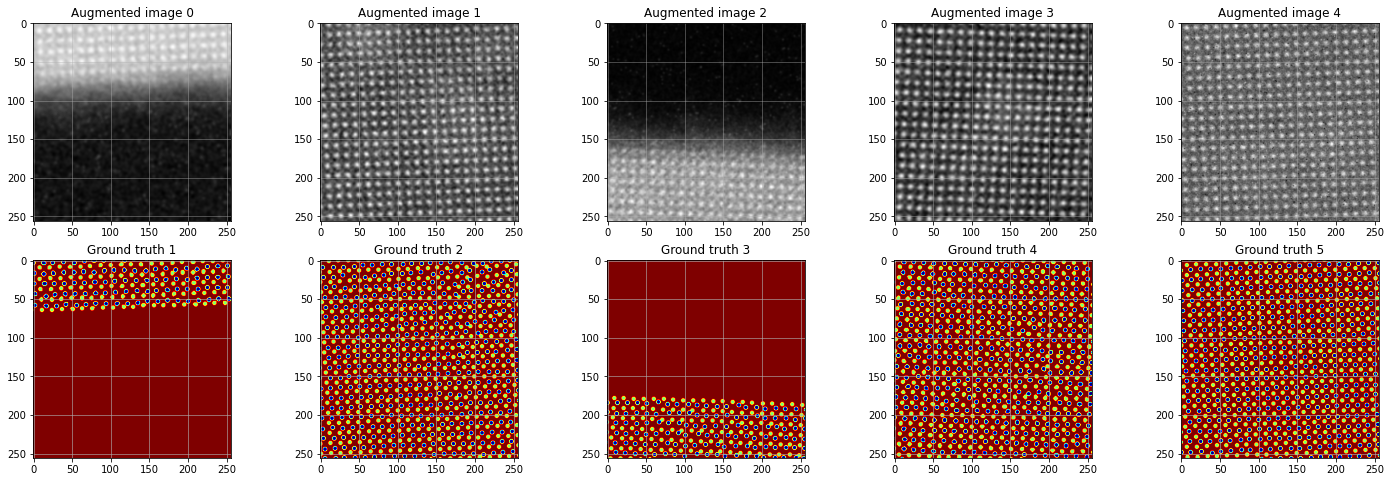

In [41]:
n = 5

n = n + 1
fig = plt.figure( figsize=(30, 8))
for i in range(1, n):   
    ax = fig.add_subplot(2, n, i)
    ax.imshow(images_all[i-1,0,:,:], cmap='gray')
    ax.set_title('Augmented image ' + str(i-1) )
    ax.grid(alpha = 0.5)
    ax = fig.add_subplot(2, n, i+n)
    if labels_all.shape[1] == 1:
        ax.imshow(labels_all[i-1, 0], cmap='jet', interpolation='Gaussian')
    else:
        ax.imshow(labels_all[i-1], cmap='jet', interpolation='Gaussian')
    ax.set_title('Ground truth ' + str(i))
    ax.grid(alpha=0.75)

## Save data

Finally, we split out image-mask pairs into training and test sets...

In [0]:
from sklearn.model_selection import train_test_split
images_all, images_test_all, labels_all, labels_test_all = train_test_split(
    images_all, labels_all, test_size=0.2, random_state=42)

... and save them for future use

In [0]:
from google.colab import drive
drive.mount('/content/drive')

np.savez('/content/drive/My Drive/SimulatedAtomicImages/ferroics-exp-labeled-small.npz', 
         X_train=images_all, X_test=images_test_all, y_train=labels_all, y_test=labels_test_all)